In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import numpy as np
import torch.nn as nn
import torch.optim as optim

**Preprocess and datset download**

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()  # Converts image to a tensor with [0, 1] values
])

train_val_dataset = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)


Files already downloaded and verified
Files already downloaded and verified


**Split**

In [3]:
train_size = 40000
val_size = 10000
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

**Showing a random image of each class**

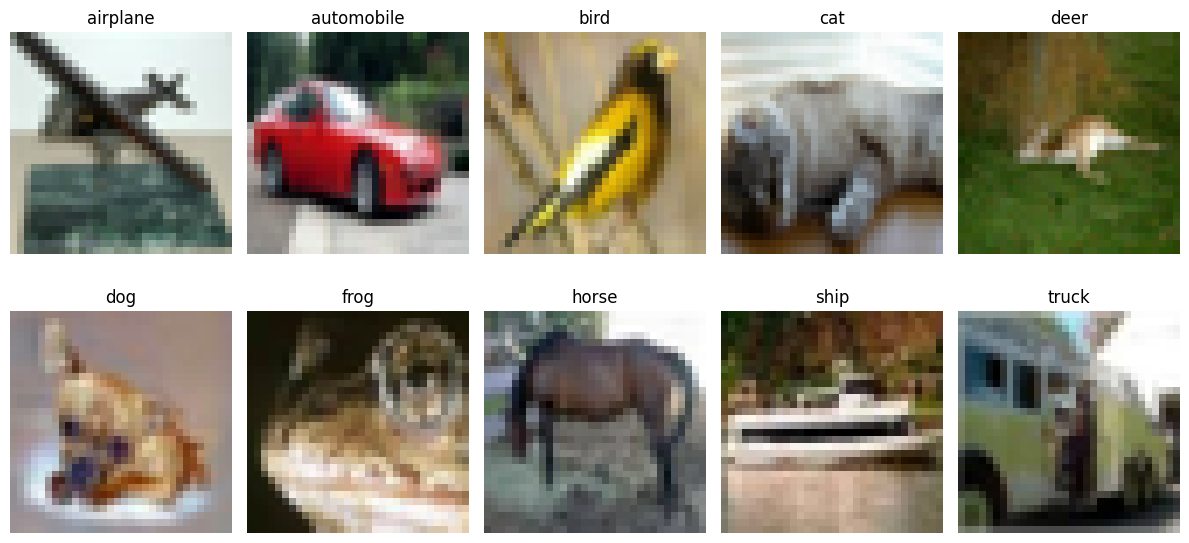

In [4]:
class_labels = test_dataset.classes

class_indices = {label: [] for label in range(10)}
for idx, (_, label) in enumerate(test_dataset):
    class_indices[label].append(idx)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()
for class_id, ax in enumerate(axes):
    random_idx = random.choice(class_indices[class_id])
    image, label = test_dataset[random_idx]
    image = np.transpose(image.numpy(), (1, 2, 0))
    image = (image - image.min()) / (image.max() - image.min())
    ax.imshow(image)
    ax.axis("off")
    ax.set_title(class_labels[label])

plt.tight_layout()
plt.show()

**Data Loaders**

In [5]:
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")

Training set: 40000 samples
Validation set: 10000 samples
Test set: 10000 samples


**given code**

In [6]:
class BaselineModel(nn.Module):
    def __init__(self):
        super(BaselineModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 14 * 14, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
baseline_model = BaselineModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(baseline_model.parameters(), lr=0.01, momentum=0.9)

**train and test the netwrok**

In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            #loss
            loss = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)  # Multiply it by batch size

            #accuracy
            _, predicted = torch.max(outputs, 1)  # Get predicted class with the highest score
            correct += (predicted == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Count total samples

    # Average loss and accuracy
    avg_loss = total_loss / total_samples
    accuracy = correct / total_samples * 100

    return avg_loss, accuracy

# val_loss, val_accuracy = evaluate_model(baseline_model, val_loader, criterion, device)
# test_loss, test_accuracy = evaluate_model(baseline_model, test_loader, criterion, device)

# print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")
# print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30):
    best_val_loss = float('inf')
    best_model_weights = None

    # Log metrics
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        total_correct = 0
        total_samples = 0

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)  # Accumulate loss and multiply by batch size
            _, predicted = torch.max(outputs, 1)  # Predicted class
            total_correct += (predicted == labels).sum().item()  # Count correct predictions
            total_samples += labels.size(0)  # Count total samples

        # Calculate training loss and accuracy
        train_loss = running_loss / total_samples
        train_accuracy = total_correct / total_samples * 100
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        # Evaluate on validation set
        val_loss, val_accuracy = evaluate_model(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()  # Save best model parameters
            torch.save(best_model_weights, "best_model.pth")  # Save checkpoint
            print("******************_file updated_*****************")

        # Print epoch statistics
        print(f"Epoch {epoch+1}/{num_epochs}")
        print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"  Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")
        print(f"  Best Val Loss: {best_val_loss:.4f}")

    return train_losses, train_accuracies, val_losses, val_accuracies


In [9]:
num_epochs = 30
learning_rate = 0.01
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(baseline_model.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    baseline_model, train_loader, val_loader, criterion, optimizer, device, num_epochs=30
)

******************_file updated_*****************
Epoch 1/30
  Train Loss: 1.6596, Train Accuracy: 40.99%
  Val Loss: 1.4604, Val Accuracy: 48.87%
  Best Val Loss: 1.4604
******************_file updated_*****************
Epoch 2/30
  Train Loss: 1.3769, Train Accuracy: 51.96%
  Val Loss: 1.2880, Val Accuracy: 55.32%
  Best Val Loss: 1.2880
******************_file updated_*****************
Epoch 3/30
  Train Loss: 1.2328, Train Accuracy: 57.17%
  Val Loss: 1.2148, Val Accuracy: 58.35%
  Best Val Loss: 1.2148
Epoch 4/30
  Train Loss: 1.1512, Train Accuracy: 60.44%
  Val Loss: 1.2212, Val Accuracy: 57.96%
  Best Val Loss: 1.2148
******************_file updated_*****************
Epoch 5/30
  Train Loss: 1.0869, Train Accuracy: 62.62%
  Val Loss: 1.1277, Val Accuracy: 61.41%
  Best Val Loss: 1.1277
Epoch 6/30
  Train Loss: 1.0502, Train Accuracy: 64.05%
  Val Loss: 1.1517, Val Accuracy: 60.86%
  Best Val Loss: 1.1277
Epoch 7/30
  Train Loss: 1.0172, Train Accuracy: 65.01%
  Val Loss: 1.1839

**plots**

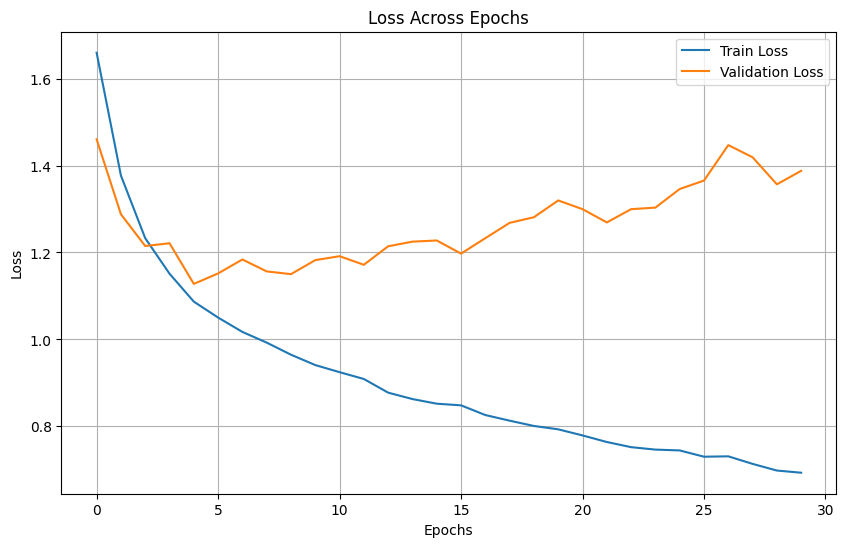

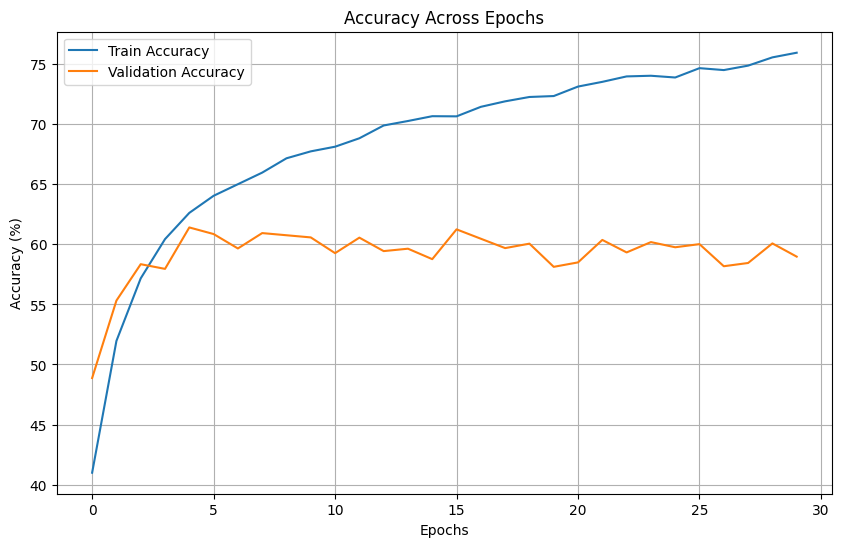

In [10]:
def plot_metrics(train_metrics, val_metrics, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(val_metrics, label=f"Validation {metric_name}")
    plt.title(f"{metric_name} Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_metrics(train_losses, val_losses, "Loss", "Loss")
plot_metrics(train_accuracies, val_accuracies, "Accuracy", "Accuracy (%)")

**Accuracy and loss for the best model saved**

In [13]:
best_model = BaselineModel().to(device)
best_model.load_state_dict(torch.load("best_model.pth"))
test_loss, test_accuracy = evaluate_model(best_model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

<ipython-input-13-70165689d4f0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model.load_state_dict(torch.load("best_model.pth"))


Test Loss: 1.1259, Test Accuracy: 61.03%


**c) upgrade base model**

In [14]:
class UpgradedModel(nn.Module):
    def __init__(self):
        super(UpgradedModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)  # input size is 32x32
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)  # Output for 10 classes

        # Activation function
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UpgradedModel = UpgradedModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(UpgradedModel.parameters(), lr=0.01, momentum=0.9)

In [15]:
num_epochs = 30
learning_rate = 0.01
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(UpgradedModel.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    UpgradedModel, train_loader, val_loader, criterion, optimizer, device, num_epochs=30
)

******************_file updated_*****************
Epoch 1/30
  Train Loss: 2.0861, Train Accuracy: 22.91%
  Val Loss: 1.8494, Val Accuracy: 32.40%
  Best Val Loss: 1.8494
******************_file updated_*****************
Epoch 2/30
  Train Loss: 1.6310, Train Accuracy: 40.75%
  Val Loss: 1.4705, Val Accuracy: 45.15%
  Best Val Loss: 1.4705
******************_file updated_*****************
Epoch 3/30
  Train Loss: 1.3091, Train Accuracy: 52.53%
  Val Loss: 1.1901, Val Accuracy: 57.21%
  Best Val Loss: 1.1901
******************_file updated_*****************
Epoch 4/30
  Train Loss: 1.0657, Train Accuracy: 61.89%
  Val Loss: 1.0140, Val Accuracy: 64.24%
  Best Val Loss: 1.0140
******************_file updated_*****************
Epoch 5/30
  Train Loss: 0.8489, Train Accuracy: 69.92%
  Val Loss: 0.9020, Val Accuracy: 68.39%
  Best Val Loss: 0.9020
******************_file updated_*****************
Epoch 6/30
  Train Loss: 0.6567, Train Accuracy: 76.69%
  Val Loss: 0.8880, Val Accuracy: 69.75

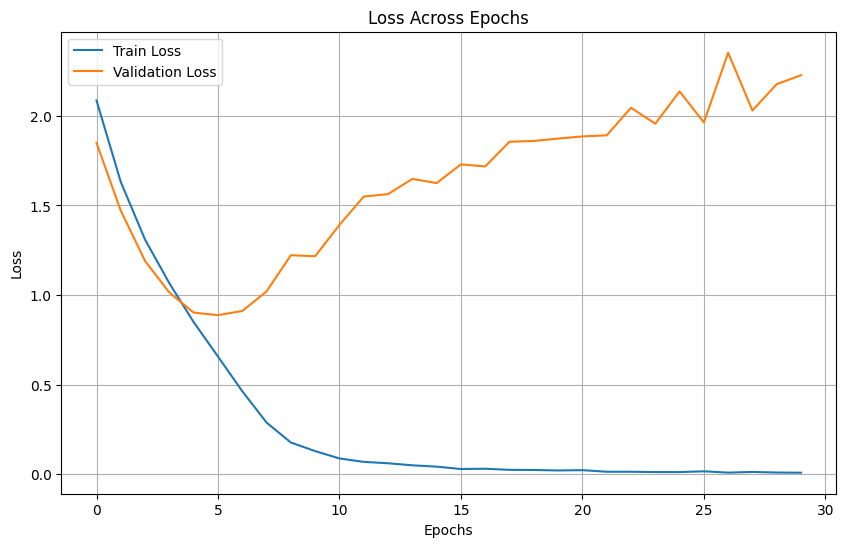

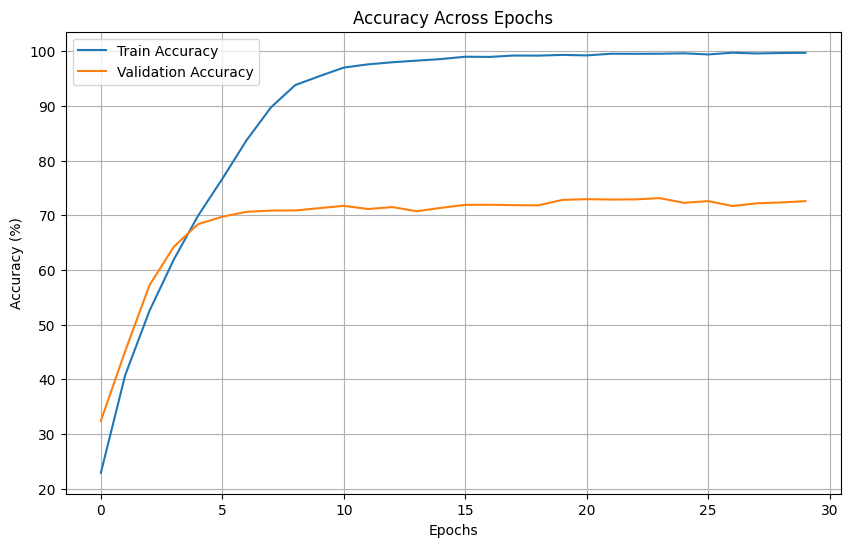

In [16]:
def plot_metrics(train_metrics, val_metrics, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(val_metrics, label=f"Validation {metric_name}")
    plt.title(f"{metric_name} Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_metrics(train_losses, val_losses, "Loss", "Loss")
plot_metrics(train_accuracies, val_accuracies, "Accuracy", "Accuracy (%)")

In [17]:
# Evaluate the model
test_loss, test_accuracy = evaluate_model(UpgradedModel, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")


Test Loss: 2.2599, Test Accuracy: 72.48%


**َAs we see upgraded netwrok with more layers and depth with different kernels is better than the base line model that is not very deep. here our model accuracy on test data is approximatly 10 percent better than the base model.**

**d) adding batch normalization**

In [18]:
class UpgradedModelWithBN(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UpgradedModelWithBN = UpgradedModelWithBN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(UpgradedModelWithBN.parameters(), lr=0.01, momentum=0.9)

In [19]:
num_epochs = 30
learning_rate = 0.01
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(UpgradedModelWithBN.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    UpgradedModelWithBN, train_loader, val_loader, criterion, optimizer, device, num_epochs=30
)

******************_file updated_*****************
Epoch 1/30
  Train Loss: 1.3085, Train Accuracy: 52.28%
  Val Loss: 1.0581, Val Accuracy: 62.92%
  Best Val Loss: 1.0581
******************_file updated_*****************
Epoch 2/30
  Train Loss: 0.8707, Train Accuracy: 69.27%
  Val Loss: 0.9555, Val Accuracy: 68.65%
  Best Val Loss: 0.9555
******************_file updated_*****************
Epoch 3/30
  Train Loss: 0.6897, Train Accuracy: 75.72%
  Val Loss: 0.7896, Val Accuracy: 73.15%
  Best Val Loss: 0.7896
******************_file updated_*****************
Epoch 4/30
  Train Loss: 0.5752, Train Accuracy: 79.70%
  Val Loss: 0.7269, Val Accuracy: 75.77%
  Best Val Loss: 0.7269
******************_file updated_*****************
Epoch 5/30
  Train Loss: 0.4800, Train Accuracy: 83.10%
  Val Loss: 0.7115, Val Accuracy: 76.42%
  Best Val Loss: 0.7115
******************_file updated_*****************
Epoch 6/30
  Train Loss: 0.3952, Train Accuracy: 85.89%
  Val Loss: 0.6949, Val Accuracy: 77.97

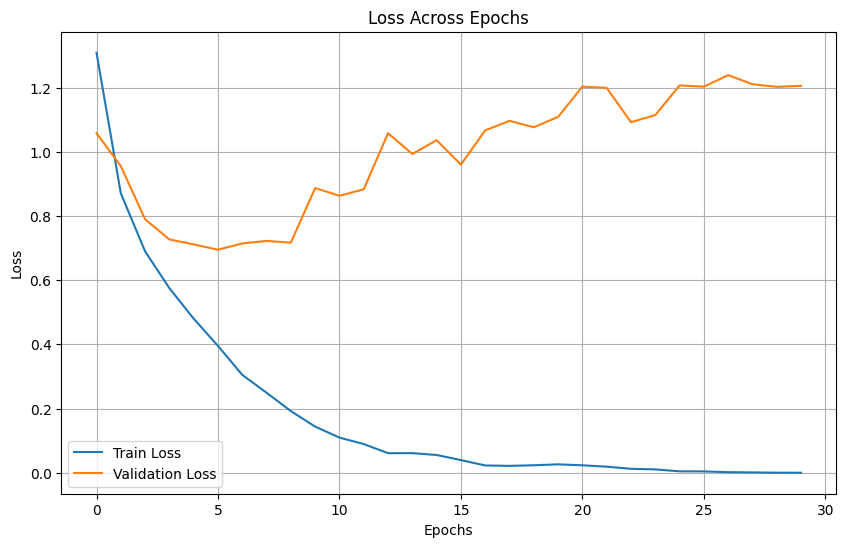

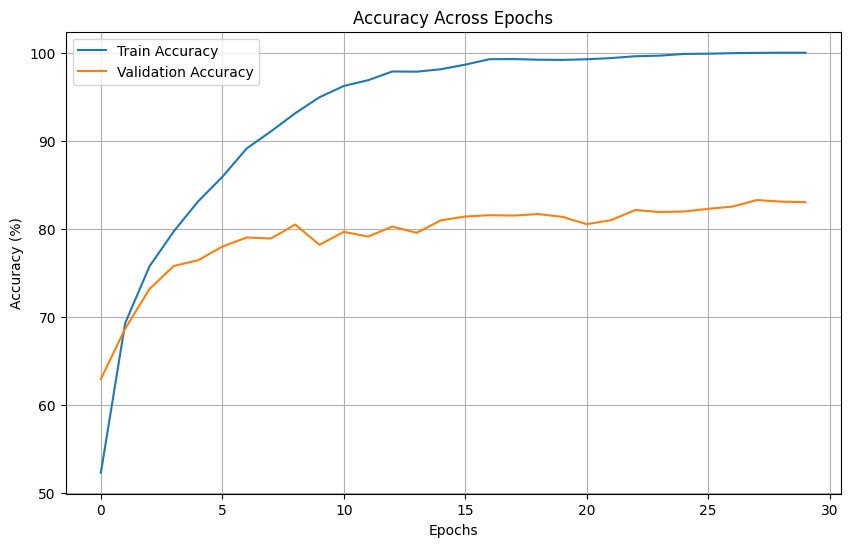

In [20]:
def plot_metrics(train_metrics, val_metrics, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(val_metrics, label=f"Validation {metric_name}")
    plt.title(f"{metric_name} Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_metrics(train_losses, val_losses, "Loss", "Loss")
plot_metrics(train_accuracies, val_accuracies, "Accuracy", "Accuracy (%)")

In [21]:
# Evaluate the model
test_loss, test_accuracy = evaluate_model(UpgradedModelWithBN, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 1.2548, Test Accuracy: 82.73%


**َAs we see Batch Normalization improves networks by stabilizing activations, preventing vanishing/exploding gradients, enabling faster training with higher learning rates, and reducing overfitting through implicit regularization. here our model accuracy on test data is approximatly 10 percent better than the base model.**


**e) adding Dropout to network**

In [37]:
class UpgradedModelWithBNandDropout(nn.Module):
    def __init__(self):
        super(UpgradedModelWithBNandDropout, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 8 * 8, 512)
        self.dropout1 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc3 = nn.Linear(128, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropout1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
UpgradedModelWithBNandDropout = UpgradedModelWithBNandDropout().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(UpgradedModelWithBNandDropout.parameters(), lr=0.01, momentum=0.9)

In [38]:
num_epochs = 30
learning_rate = 0.01
momentum = 0.9
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.SGD(UpgradedModelWithBNandDropout.parameters(), lr=learning_rate, momentum=momentum)

train_losses, train_accuracies, val_losses, val_accuracies = train_model(
    UpgradedModelWithBNandDropout, train_loader, val_loader, criterion, optimizer, device, num_epochs=30
)

******************_file updated_*****************
Epoch 1/30
  Train Loss: 1.4431, Train Accuracy: 46.95%
  Val Loss: 1.0820, Val Accuracy: 61.16%
  Best Val Loss: 1.0820
******************_file updated_*****************
Epoch 2/30
  Train Loss: 1.0027, Train Accuracy: 64.98%
  Val Loss: 0.9361, Val Accuracy: 67.93%
  Best Val Loss: 0.9361
Epoch 3/30
  Train Loss: 0.8294, Train Accuracy: 71.07%
  Val Loss: 0.9918, Val Accuracy: 68.19%
  Best Val Loss: 0.9361
******************_file updated_*****************
Epoch 4/30
  Train Loss: 0.7303, Train Accuracy: 74.72%
  Val Loss: 0.7877, Val Accuracy: 72.77%
  Best Val Loss: 0.7877
******************_file updated_*****************
Epoch 5/30
  Train Loss: 0.6389, Train Accuracy: 77.90%
  Val Loss: 0.6598, Val Accuracy: 77.57%
  Best Val Loss: 0.6598
******************_file updated_*****************
Epoch 6/30
  Train Loss: 0.5658, Train Accuracy: 80.40%
  Val Loss: 0.6199, Val Accuracy: 79.10%
  Best Val Loss: 0.6199
Epoch 7/30
  Train Loss:

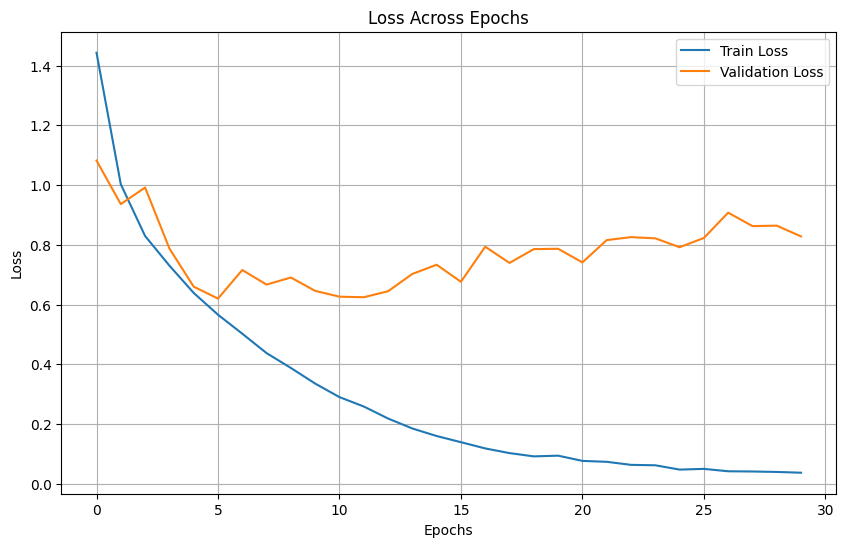

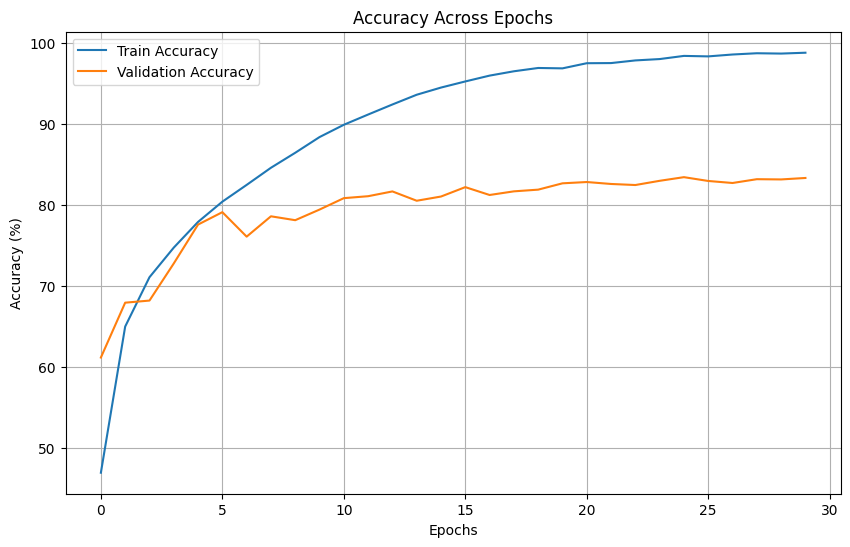

In [39]:
def plot_metrics(train_metrics, val_metrics, metric_name, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(train_metrics, label=f"Train {metric_name}")
    plt.plot(val_metrics, label=f"Validation {metric_name}")
    plt.title(f"{metric_name} Across Epochs")
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()
plot_metrics(train_losses, val_losses, "Loss", "Loss")
plot_metrics(train_accuracies, val_accuracies, "Accuracy", "Accuracy (%)")

In [40]:
# Evaluate the model
test_loss, test_accuracy = evaluate_model(UpgradedModelWithBNandDropout, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.8746, Test Accuracy: 83.07%


**Adding dropout layers between fully connected (FC) layers improved model's accuracy by 1-2%, showcasing its effectiveness in enhancing generalization. Dropout works by randomly deactivating a fraction of neurons during training, forcing the model to rely on multiple pathways to make predictions. This reduces the risk of overfitting, as the network becomes less dependent on specific neurons and learns more robust features. The improvement indicates that dropout effectively mitigated over-reliance on certain patterns in the training data, resulting in better performance on unseen test images.**

Evaluating Baseline Model
Model: Baseline
Test Loss: 1.1259
Test Accuracy: 61.03%


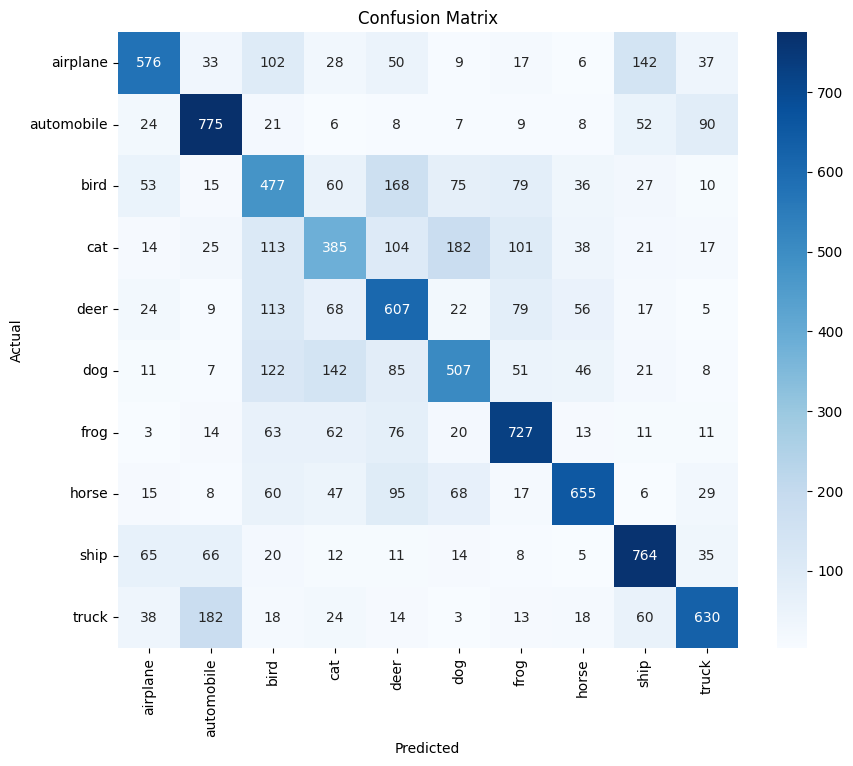

Evaluating Upgraded Model Model
Model: Upgraded Model
Test Loss: 2.2599
Test Accuracy: 72.48%


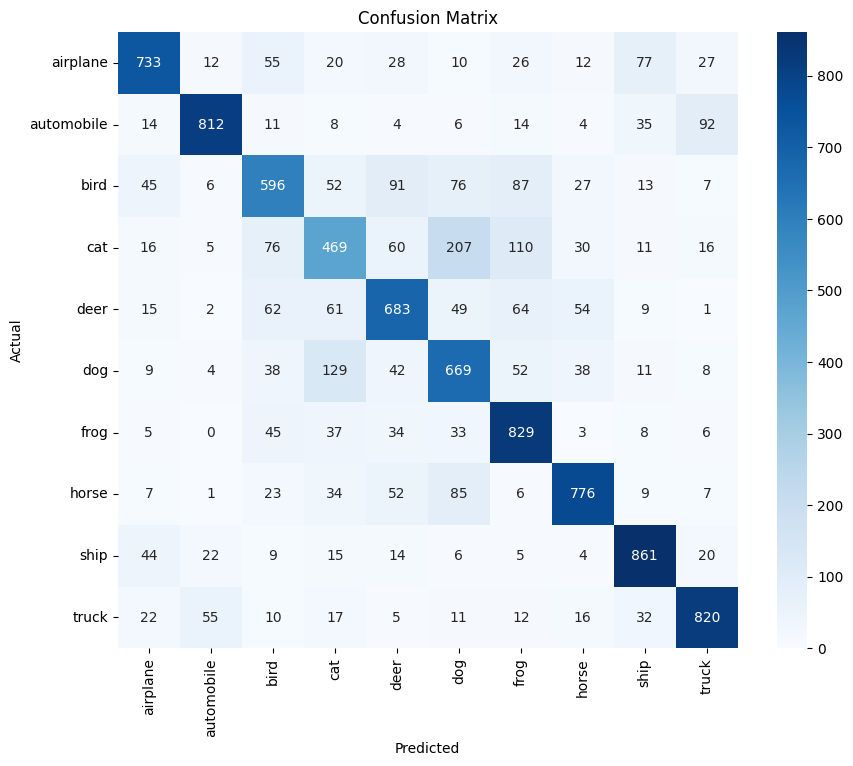

Evaluating Upgraded Model with BN Model
Model: Upgraded Model with BN
Test Loss: 1.2548
Test Accuracy: 82.73%


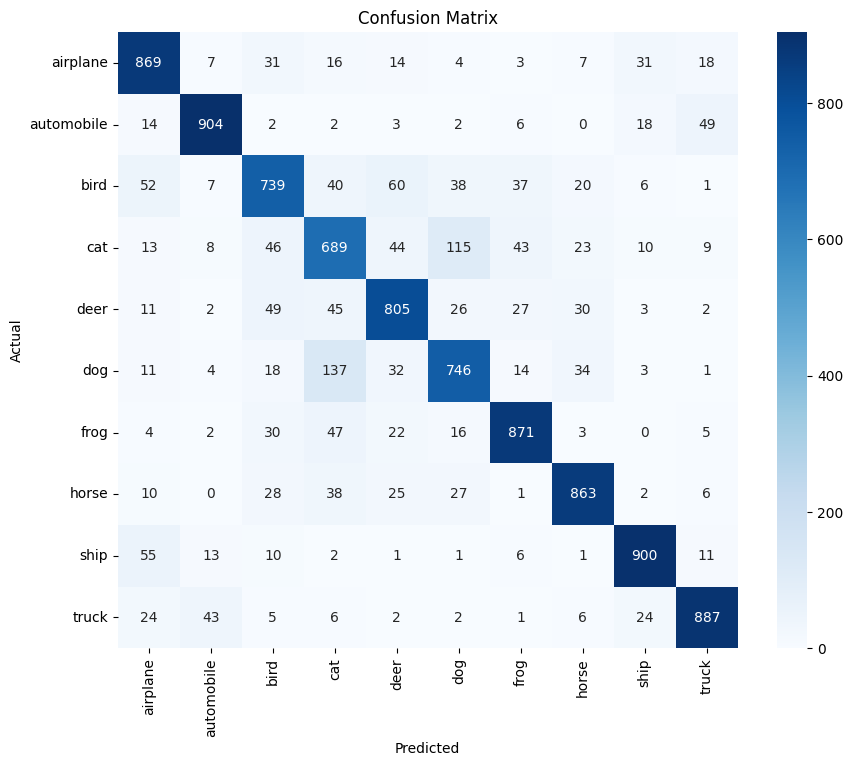

Evaluating Upgraded Model with BN and Dropout Model
Model: Upgraded Model with BN and Dropout
Test Loss: 0.8746
Test Accuracy: 83.07%


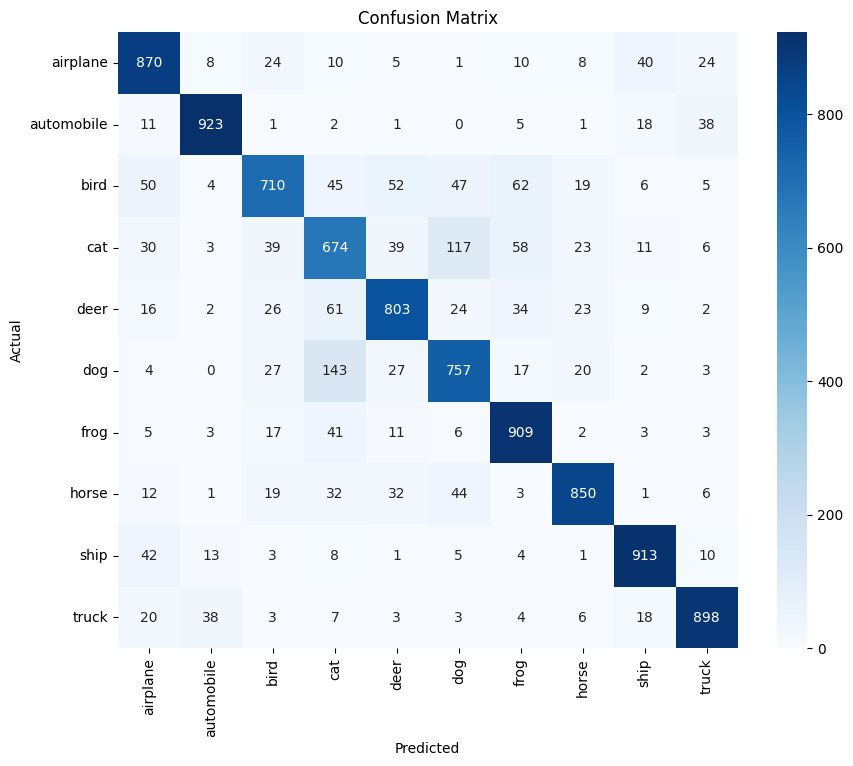

In [41]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

def classify_and_evaluate(model, test_loader, criterion, device):
    model.eval()  # Set the model to evaluation mode
    all_predictions = []
    all_labels = []
    test_loss = 0.0
    total_samples = 0
    correct_predictions = 0

    with torch.no_grad():  # Disable gradient calculation for evaluation
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)  # Accumulate loss
            _, predicted = torch.max(outputs, 1)  # Get predictions
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    # Calculate accuracy
    test_accuracy = correct_predictions / total_samples * 100
    test_loss /= total_samples

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return test_loss, test_accuracy, conf_matrix

def plot_confusion_matrix(conf_matrix, class_names):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

# Models and their corresponding names
models = {
    "Baseline": best_model.to(device),
    "Upgraded Model": UpgradedModel.to(device),
    "Upgraded Model with BN": UpgradedModelWithBN.to(device),
    "Upgraded Model with BN and Dropout": UpgradedModelWithBNandDropout.to(device)
}

class_names = test_loader.dataset.classes  # CIFAR-10 class names

for model_name, model_instance in models.items():
    print(f"Evaluating {model_name} Model")

    # Evaluate the model
    test_loss, test_accuracy, conf_matrix = classify_and_evaluate(model_instance, test_loader, criterion, device)

    # Print results
    print(f"Model: {model_name}")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Plot confusion matrix
    plot_confusion_matrix(conf_matrix, class_names)
